# **EXPLANATORY DATA ANALYSIS**

#### IMPORT REQUIRED LIBRARIES

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

---

#### LOAD DATASET

In [3]:
# Load the Stack Overflow survey data
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv'
df = pd.read_csv(data_url)

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

---

#### HANDLE MISSING DATA

Identify and manage missing values in critical columns such as `Employment`, `JobSat`, and `RemoteWork`. Implement a strategy to fill or drop these values, depending on the significance of the missing data.

In [4]:
print(df[['Employment', 'JobSat', 'RemoteWork']].dtypes)
#df[['Employment', 'JobSat', 'RemoteWork']]

Employment     object
JobSat        float64
RemoteWork     object
dtype: object


In [5]:
print(f"Total Rows: {len(df)}")
print(f"Employment missing values: {df['Employment'].isna().sum()}")
print(f"Jobsat missing values: {df['JobSat'].isna().sum()}")
print(f"RemoteWork missing values: {df['RemoteWork'].isna().sum()}")

Total Rows: 65437
Employment missing values: 0
Jobsat missing values: 36311
RemoteWork missing values: 10631


For `Jobsat` and `RemoteWork` i think it's not wise to fill **NaN** with *forward-fill* or *mode*. Dropping them also would be a data *messacre* since the number of missing values are too high, especially for `JobSat` (36311 missing values). I'll fill **NaN** with new category called **'Not Applicable'** for `RemoteWork` and `-1` for `JobSat` as the safest option.

In [6]:
# Fill missing 'JobSat' NaN with new category 'Not Applicable'
df['JobSat'] = df['JobSat'].fillna(-1)

# Fill missing 'RemoteWork' NaN with new category 'Not Applicable'
df['RemoteWork'] = df['RemoteWork'].fillna('Not Applicable')

# Verify
print(f"Number of missing values of Jobsat and RemoteWork:\n{df[['JobSat', 'RemoteWork']].isna().sum()}")

Number of missing values of Jobsat and RemoteWork:
JobSat        0
RemoteWork    0
dtype: int64


---

#### ANALYSIS OF EXPERIENCE AND JOB SATISFACTION

Analyze the relationship between years of professional coding experience (`YearsCodePro`) and job satisfaction (`JobSat`). Summarize `YearsCodePro` and calculate median satisfaction scores based on experience ranges.

- Create experience ranges for `YearsCodePro` (e.g., `0-5`, `5-10`, `10-20`, `>20` years).

- Calculate the median `JobSat` for each range.

- Visualize the relationship using a bar plot or similar visualization.


In [7]:
# Create replace map to change string value to numerical
replace_map = {
    'Less than 1 year' : 0,
    'More than 50 years' : 51
}

# replace string to numerical value
df['YearsCodePro'] = df['YearsCodePro'].replace(replace_map)

# Check number of missing value before converting
print(f"Number of missing values: {df['YearsCodePro'].isna().sum()}")

# Convert all value to numerical
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

print(f"Number of missing values after converting: {df['YearsCodePro'].isna().sum()}")

Number of missing values: 13827
Number of missing values after converting: 13827


#### Handle missing values first before further analyze the data

Since there are students category in `Employment` column, we will fill `YearsCodePro` with those category with 0 experience first. Then fill the rest with median.

In [8]:
# ---HANDLE MISSING YEARS CODE PRO DATA---
# Create a filter for student and unemployed
student_mask = df['Employment'].str.contains("Student|Not employed", case=False, na=False)
df.loc[student_mask, 'YearsCodePro'] = df.loc[student_mask, 'YearsCodePro'].fillna(0)

# Then fill the rest with median
exp_median = df['YearsCodePro'].median()
df['YearsCodePro'] = df['YearsCodePro'].fillna(exp_median)

print(f"Remaining missing values: {df['YearsCodePro'].isna().sum()}")

Remaining missing values: 0


#### Feature Engineering

In [9]:
# Create bins and categories
bins = [-1, 2, 5, 10, 52]
labels= ['Junior', 'Mid-level', 'Senior', 'Expert']
df['ExperienceCategory'] = pd.cut(df['YearsCodePro'], bins=bins, labels=labels)

#### Calculate Job Satisfactoin Median for each Experience Category

Since there are numerous **"Student"** category that included as **"Junior"** category, but previously we set their `JobSat` value to -1 ('Not Applicable'). Because of that, i'll filter out `JobSat` with -1 values, so they won't drag the score down, which will intrepreted as *"Juniors hate their job"* (false or miss intrepret).

In [10]:
median_satisfactory = df[df['JobSat'] >= 0].groupby('ExperienceCategory', observed=False)['JobSat'].median()

median_satisfactory

ExperienceCategory
Junior       7.0
Mid-level    7.0
Senior       7.0
Expert       8.0
Name: JobSat, dtype: float64

----

#### VISUALIZE

We'll visualize `JobSat` into a `countplot`

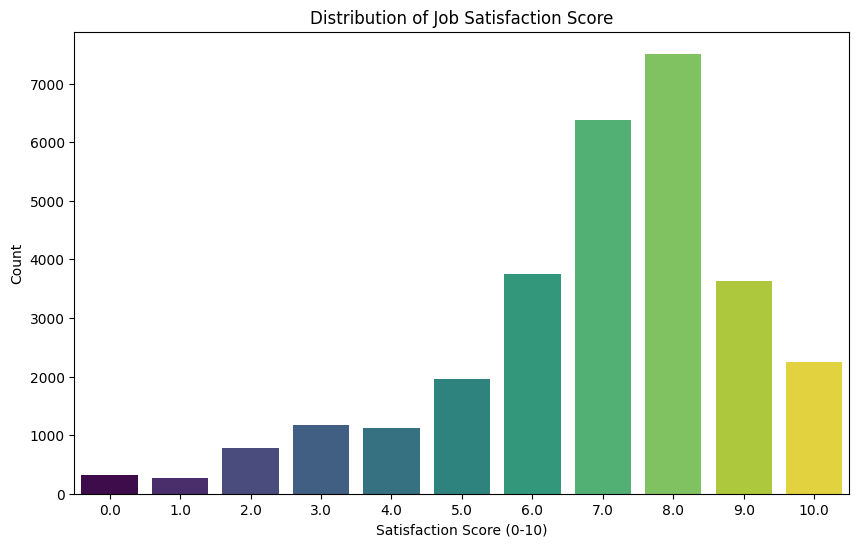

In [11]:
# Create Figure
plt.figure(figsize=(10,6))

# Filter out -1 (not applicable)
applicable = df[df['JobSat'] >= 0]

# Create plot
sns.countplot(x='JobSat', data=applicable, order=sorted(applicable['JobSat'].unique()),
               palette='viridis', hue='JobSat', legend=False)

# Add title and labels
plt.title('Distribution of Job Satisfaction Score')
plt.xlabel('Satisfaction Score (0-10)')
plt.ylabel('Count')

# Display the chart
plt.show()

#### ANALYZING REMOTE WORK PREFERENCES BY JOB ROLE

Analyze trends in remote work based on job roles. We'll use the `RemoteWork` and `Employment` columns to explore preferences and examine if specific job roles prefer remote work more than others.

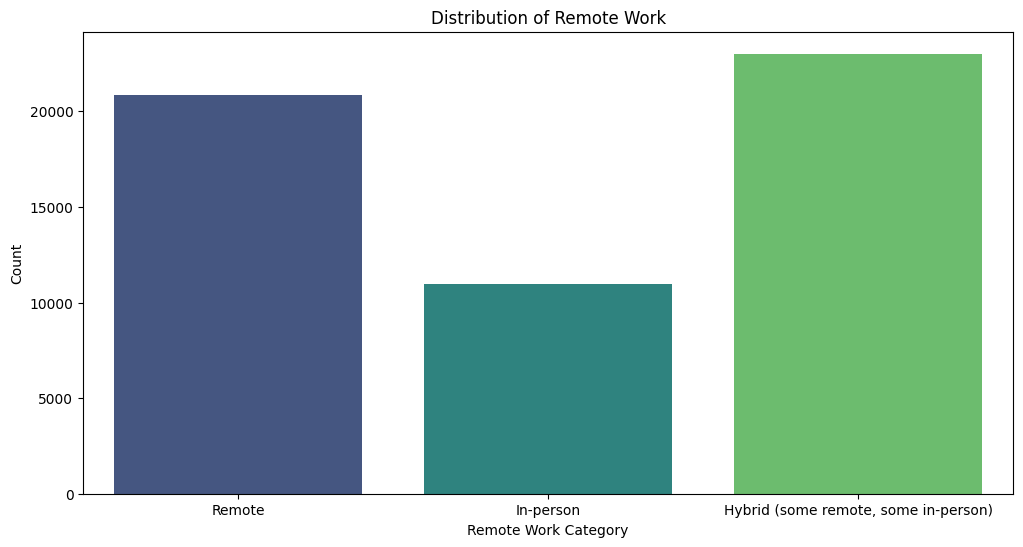

In [15]:
# ---VISUALIZE REMOTE WORK DISTRIBUTION---
plt.figure(figsize=(12,6))

applicable_rw = df[df['RemoteWork'] != 'Not Applicable']
sns.countplot(x='RemoteWork', data=applicable_rw, palette='viridis', hue='RemoteWork', legend=False)

plt.title("Distribution of Remote Work")
plt.xlabel("Remote Work Category")
plt.ylabel('Count')

plt.show()

In [23]:
# ---CROSSTAB REMOTE WORK BY EMPLOYMENT---
crosstab = (pd.crosstab(index=df['Employment'], columns=df['RemoteWork'],
                       normalize='index') * 100).round(2)       # Normalize and turn it into percentage for readability
                                                                # rounded by 2 decimals

crosstab.sample(20)

RemoteWork,"Hybrid (some remote, some in-person)",In-person,Not Applicable,Remote
Employment,,,,
"Student, full-time;Not employed, but looking for work;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work",0.00,0.00,0.00,100.00
"Not employed, but looking for work;Independent contractor, freelancer, or self-employed",23.50,6.27,1.04,69.19
"Student, full-time",0.00,0.00,100.00,0.00
"Employed, full-time;Independent contractor, freelancer, or self-employed;Student, part-time;Retired",0.00,0.00,0.00,100.00
"Student, full-time;Student, part-time;Retired",0.00,0.00,100.00,0.00
"Employed, full-time;Not employed, but looking for work;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work;Employed, part-time",25.00,0.00,0.00,75.00
"Employed, full-time;Student, full-time;Independent contractor, freelancer, or self-employed;Student, part-time;Employed, part-time",50.00,50.00,0.00,0.00
"Not employed, but looking for work;Independent contractor, freelancer, or self-employed;Not employed, and not looking for work;Retired",0.00,0.00,0.00,100.00
"Student, full-time;Student, part-time",0.00,0.00,100.00,0.00


---

#### ANALYZING PROGRAMMING LANGUAGE TRENDS BY REGION

Analyze the popularity of programming languages by region. I'll use the `LanguageHaveWorkedWith` column to investigate which languages are most used in different regions.

But since the values in `LanguageHaveWorkedWith` is a bit messy, I'll clean it first.

In [36]:
# ---DATA CLEANING---

# Drop missing values
df_langs = df[['Country', 'LanguageHaveWorkedWith']].dropna().copy()

# Split the string by ";"
# "Python;Java" becomes ["Python", "Java"]
df_langs['LanguageHaveWorkedWith'] = df_langs['LanguageHaveWorkedWith'].str.split(";")

# Explode (Turn the list into seperate rows)
df_exploaded = df_langs.explode('LanguageHaveWorkedWith')

df_exploaded.head(10)

,Country,LanguageHaveWorkedWith
1,United Kingdom of Great Britain and Northern I...,Bash/Shell (all shells)
1,United Kingdom of Great Britain and Northern I...,Go
1,United Kingdom of Great Britain and Northern I...,HTML/CSS
1,United Kingdom of Great Britain and Northern I...,Java
1,United Kingdom of Great Britain and Northern I...,JavaScript
1,United Kingdom of Great Britain and Northern I...,Python
1,United Kingdom of Great Britain and Northern I...,TypeScript
2,United Kingdom of Great Britain and Northern I...,C#
3,Canada,C
3,Canada,C++


#### VISUALIZE PROGRAMMING LANGUAGE TRENDS IN USA

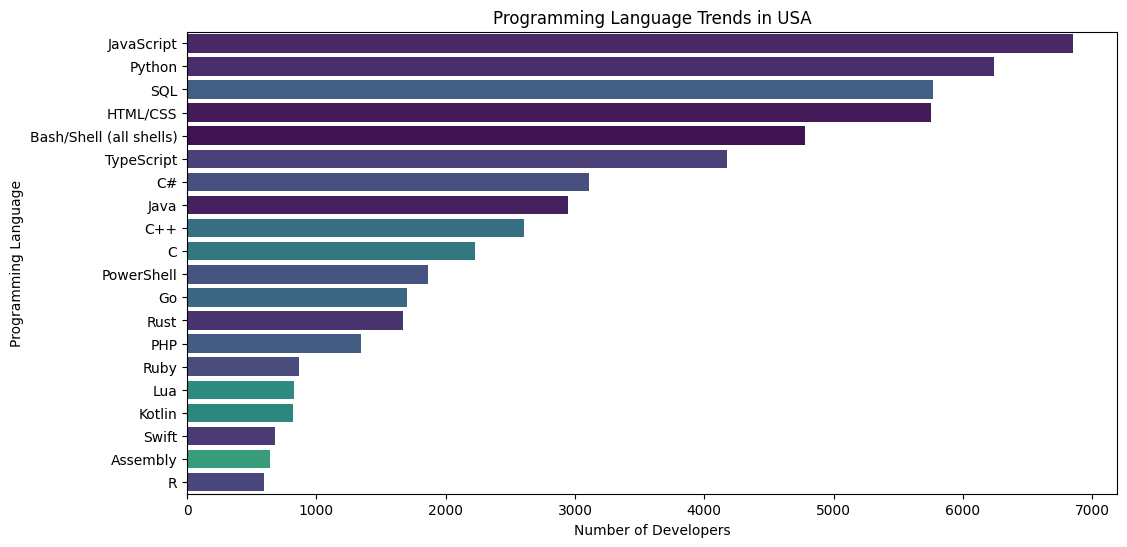

In [60]:
# Filter by USA
usa_langs = df_exploaded[df_exploaded['Country'] == 'United States of America'].reset_index(drop=True)

language_order = usa_langs['LanguageHaveWorkedWith'].value_counts().iloc[:20].index

# Create Plot
plt.figure(figsize=(12,6))
sns.countplot(y='LanguageHaveWorkedWith', data=usa_langs, palette='viridis',
              order=language_order,
              hue='LanguageHaveWorkedWith', legend=False)

plt.title("Programming Language Trends in USA")
plt.xlabel('Number of Developers')
plt.ylabel('Programming Language')

# Display
plt.show()

---

#### CORRELATION BETWEEN EXPERIENCE AND SATISFACTION

In [ ]:
df['JobSatPoints_1'].sort_values(ascending=False)

53421    100.0
38570    100.0
59622    100.0
30483    100.0
9376     100.0
         ...  
65431      NaN
65432      NaN
65433      NaN
65434      NaN
65436      NaN
Name: JobSatPoints_1, Length: 65437, dtype: float64

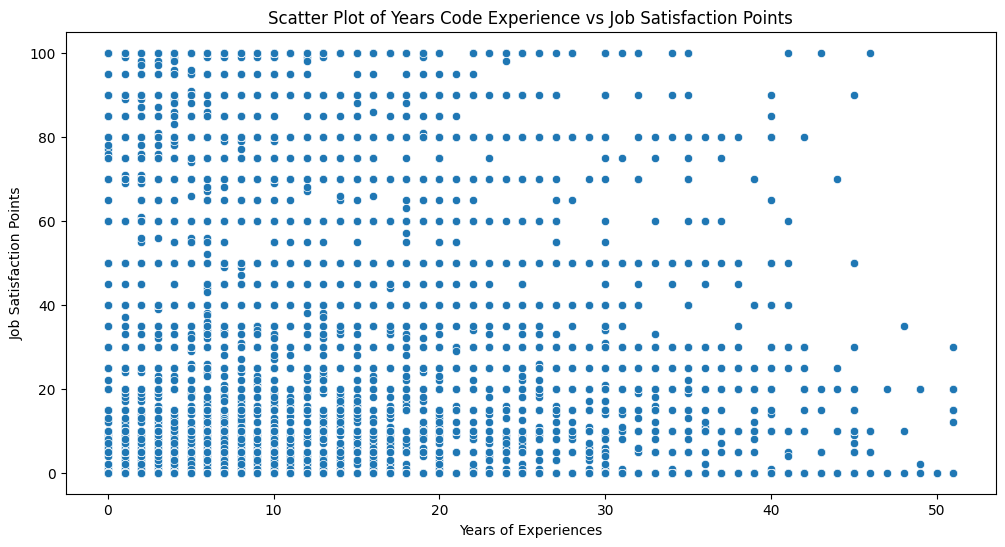

Correlation Coefficient: -0.029155025066690165


In [72]:
# Drop NaN
df_scatter = df[['YearsCodePro', 'JobSatPoints_1']].dropna().copy()

# Create Figure
plt.figure(figsize=(12,6))

# Create Plot
sns.scatterplot(x='YearsCodePro', y='JobSatPoints_1', data=df_scatter)

plt.title('Scatter Plot of Years Code Experience vs Job Satisfaction Points')
plt.xlabel('Years of Experiences')
plt.ylabel('Job Satisfaction Points')

plt.show()

# Correlation Calculation
correlation = df['YearsCodePro'].corr(df['JobSatPoints_1'])
print(f"Correlation Coefficient: {correlation}")

There's no correlation or very weak negative correlation, since the correlation coefficient close to zero (-0.029)

---

#### EDUCATIONAL BACKGROUND AND EMPLOYMENT TYPE

Explore how educational background (EdLevel) relates to employment type (Employment). Use cross-tabulation and visualizations to understand if higher education correlates with specific employment types.

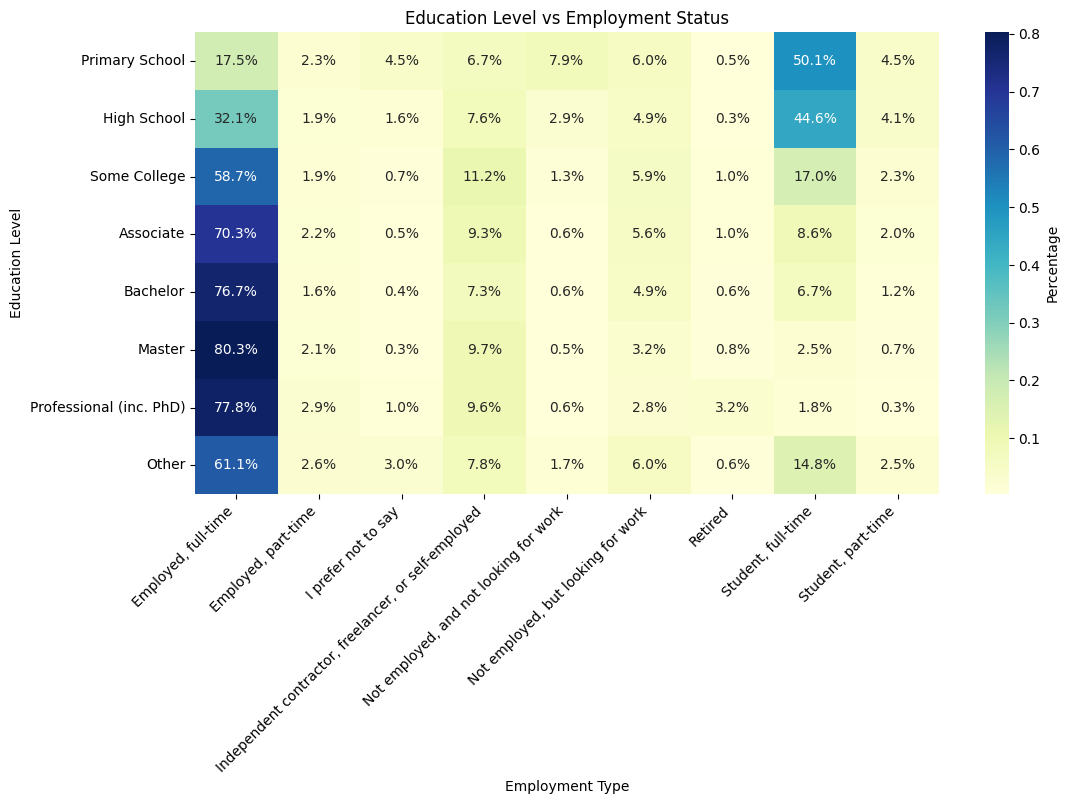

In [84]:
# 1. Clean Education Level (Same function, it works great)
def clean_education_level(text):
    text = str(text)
    if 'Bachelor' in text:
        return 'Bachelor'
    elif 'Master' in text:
        return 'Master'
    elif 'Associate' in text:
        return 'Associate'
    elif 'Secondary' in text or 'high school' in text:
        return 'High School'
    elif 'Some college' in text:
        return 'Some College'
    elif 'Professional' in text:
        return 'Professional (inc. PhD)'  # Renaming for clarity
    elif 'Primary' in text:
        return 'Primary School'
    else:
        return 'Other'

df['EdLevel_Clean'] = df['EdLevel'].apply(clean_education_level)

# 2. Clean Employment (First part only)
df['Employment_Clean'] = df['Employment'].astype(str).str.split(';').str[0]

# 3. Create Crosstab
cross_tab = pd.crosstab(df['EdLevel_Clean'], df['Employment_Clean'], normalize='index')

# 4. UPDATED Order (Removed 'Doctorate', moved Professional to top)
ed_order = [
    'Primary School', 
    'High School', 
    'Some College', 
    'Associate', 
    'Bachelor', 
    'Master', 
    'Professional (inc. PhD)', 
    'Other'
]

# Reindex and Plot
cross_tab = cross_tab.reindex(ed_order)

plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, annot=True, fmt=".1%", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.title('Education Level vs Employment Status')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel('Employment Type')
plt.ylabel('Education Level')
plt.show()

**Summary**

>Higher formal education correlates strongly with traditional full-time employment. Conversely, respondents with 'Some College' education show a higher propensity for freelance or independent work, suggesting that non-degree holders may leverage the gig economy more than degree holders.

---